# Isolate the seeds

We will go one step further with our image processing pipeline: we will extract all the individual seeds (or at least most of them) from the barley spikes. 

<img src="https://www.egr.msu.edu/~amezqui3/barley/figs/seeds_batch3a.png" width=400>

Just like in the clean-the-spike stage, this image processing pipeline uses only basic mathematical morphology operations and the parameters are ad-hoc for the data at hand.

In [1]:
import tifffile as tf
import scipy.ndimage as ndimage
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
import pandas as pd

# All the image preprocessing functions are found in `barley_brew`

- The `barley_brew` module is simply a repository of _ad hoc_ image processing functions to clean X-ray CT scans
- The module is not meant to be directly used outside the barley project, but rather provide some inspiration of what can be done to address basic X-ray CT cleaning woes.
- Hence, this notebook attempts to flesh out the functions in the module so other readers might be inspired to try similar tricks on their own.

In [2]:
import demeter.barley_brew as brew
import demeter.misc as misc

## Load the barley spike

Indicate the path `src` to the individual spikes

- The end goal is to build a loop that goes through all the spikes of the same scan
- For tutorial purposes, we'll stick to just one spike.


- We can deduce the color of the spike based on its filename, as done in the previous notebook

In [3]:
src = '../output/'
seeddst = src
figdst = src

barley_files = sorted(glob.glob(src + '*.tif'))
scanId = os.path.normpath(src).split(os.path.sep)[-1]

i = 0
fname = os.path.basename(barley_files[i])
color = (os.path.splitext(fname)[0]).split('_')[2]

print('Scan Id:\t', scanId)
print('Filename:\t', fname)
print('Color of the spike:\t', color)

Scan Id:	 example
Filename:	 S017_l0_Red_x16_y367_z176.tif
Color of the spike:	 Red


Create a folder to store the individual seeds of this particular spike. 

In [4]:
bname = os.path.splitext(fname)[0]
bname = '_'.join(bname.split('_')[1:3])
dst = src + bname + '_seeds/'
if not os.path.isdir(dst):
    os.makedirs(dst)
    print('directory', bname + '_seeds created')

directory l0_Red_seeds created


## First pass on seed extraction: `preliminary_extract`

- As suggested when normalizing densities, seeds are the most dense parts of the scans
- As we did with the spikes, we'll do an aggressive thresholding, erosions, and dilations to vanish most of the stem
- Then look for the different connected components, where each of them should ideally be an individual grain.

In [5]:
# These are ad-hoc parameters to perform the thresholding and mathematical morphology operations
cutoff = 1e-2
threshold = 190
med_tol = 0.3
padding = 7
dil = 4
thr = 120
op = 7
ero = 1
sigma = 3
iter_tol = 3
write_file=True

Load the barley spike

In [6]:
img = tf.imread(src+fname)
orig_img = img[:, 96,:].copy()
sname = os.path.splitext(fname)[0]
sname = '_'.join(sname.split('_')[0:3])
img[img < threshold] = 0
thr_img = img[:,96,:].copy()

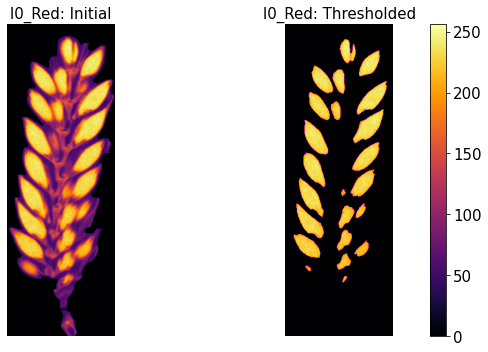

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))

i=0
mag = ax[i].imshow(orig_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': Initial', fontsize=15)
ax[i].axis('off');
i=1
mag = ax[i].imshow(thr_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': Thresholded', fontsize=15)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.1);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');

fig.tight_layout();

As in the previous notebook to separate spikes, we seek to separate the different connected components and save them as individual TIFF files in the `dst` directory.
- Only consider those components that represent at least 1% of the total nonzero voxels
    - That way we can discard noisy specks
- The connected components are labeled 0,1,...,N, sorted according to the number of nonzero voxels in each component

These operations are performed with `open_decompose`.

- `locs`: Array `N x 3` with the (x,y,z) coordinates of the lower,left,bottom corner of the box containing the component with respect to coordinates of the initial panicle scan.
- `sizes`: Array `N x 3` with the width, height, depth dimensions of the box containing the components
- `hist`: Array of length `N`. Number of nonzero voxels in each component

In [8]:
locs, sizes, hist = brew.open_decompose(dst, img, bname=bname, write_tif=True, opening=op)

- Some connected components actually contain more than one seed. 
- On the other hand, some connected components might contain a fragmented seed or a piece of stem.


We look at the number of nonzero voxels in each connected component. In this example, observe that:

- The median size of a connected component is around 50,000 non-zero voxels.
- The first three connected have almost thrice the median, and it's likely that each contain three grains
- The next five components have twice the median, and it's likely that each contain two grains

We compute the differences of nonzero voxels between consecutive components. In this example,

- The biggest changes are reported between the third and fourth components
- And between the eight and ninth components

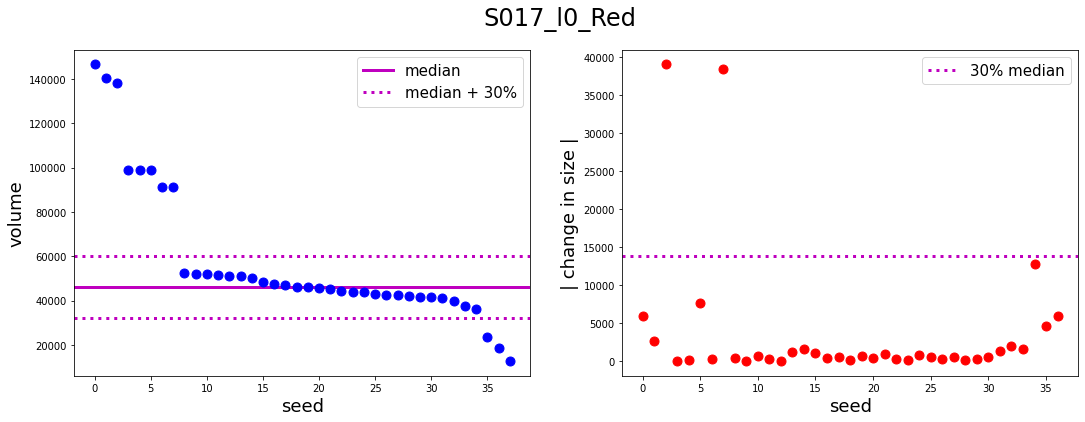

In [9]:
diff = np.abs(np.ediff1d(hist))
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
med = np.median(hist)
med_cut = med_tol*med

axes[0].axhline(med, c='m', lw=3, label='median')
axes[0].axhline(med+med_cut, c='m', lw=3, ls=':', label='median + {:.0f}%'.format(100*med_tol))
axes[0].axhline(med-med_cut, c='m', lw=3, ls=':')

axes[0].plot(hist, color='blue', marker='o', lw=0, ms=9)
axes[0].set_xlabel('seed', fontsize=18)
axes[0].set_ylabel('volume', fontsize=18)
axes[0].legend(fontsize=15)

axes[1].axhline(med_cut, c='m', lw=3, ls=':', label='{:.0f}% median'.format(100*med_tol))
axes[1].plot(diff, color='red', marker='o', lw=0, ms=9)
axes[1].set_xlabel('seed', fontsize=18)
axes[1].set_ylabel('| change in size |', fontsize=18)
axes[1].legend(fontsize=15)
fig.suptitle(sname, fontsize=24);

#fig.savefig(figdst + sname + '_preliminary.jpg', dpi=100, format='jpg', pil_kwargs={'optimize':True})

- If a connected component, in terms of nonzero voxels, is too different from the median **and** the change in size is larger than a fixed percentage of the median, then we must look into it further to break up or discard.
- We set that no single seed is has more or less than 30% voxels than the median.
- In this case, we have to analyze further the first 8 components.
- On the other hand, there are no small components to discard
    - Although their size is below the median tolerance, the change in size is **not** large enough.

In [10]:
to_split = []
to_ignore = []

for i in range(len(diff)):
    if diff[i] > med_cut  and hist[i] - med > med_cut :
        to_split.append(i+1)
    if diff[i] > med_cut  and med - hist[i+1] > med_cut :
        to_ignore.append(i+1)

if len(to_split) == 0:
    start_seed = 0
else:
    start_seed = to_split[-1]

if len(to_ignore) == 0:
    end_seed = len(locs)
else:
    end_seed = to_ignore[0]
    
print('Try to break up the first\t', start_seed, '\tcomponents')
print('Keep the first\t\t\t', end_seed, '\tcomponents, and discard the rest')

Try to break up the first	 8 	components
Keep the first			 36 	components, and discard the rest


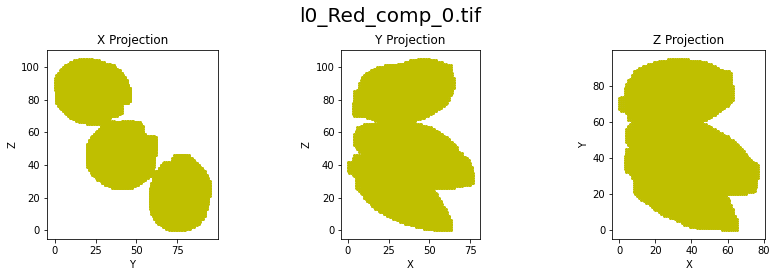

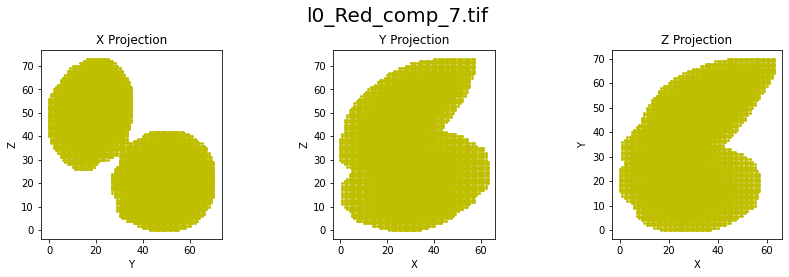

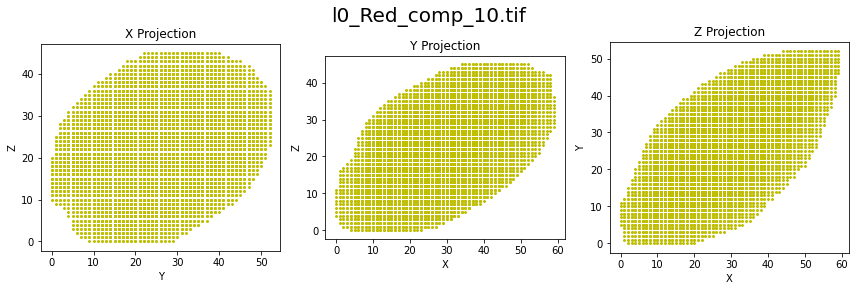

In [11]:
for i in [0,7,10]:
    seed = tf.imread(dst + bname + '_comp_{}.tif'.format(i)) 
    xyzcoords = np.nonzero(seed)
    xyzcoords = np.vstack(xyzcoords).T
    misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}.tif'.format(i))

## Second pass on seed extraction: `extract_refinement`

- We attempt to break up the large connected components that most likely contain more than one seed.
- We repeat the same basic steps of thresholding and opening the image, with the idea to eventually remove all voxels linking both seeds.
- Each time we go with a more aggressive set of parameters
- We stop until we get reasonable-sized components or if we iterate number of `iter_tols` times.


In this example, look first at `l0_Red_comp_0.tif`, which the plots above show that it is composed of actually three different seeds.

- We load `l0_Red_comp_0.tif`
- Threshold out everything with less that `195` in density
- Perform an opening considering a `7x7` kernel
- The final result is still a single connected component of volume 141,213
- Repeat again, this time with a `8x8` kernel to open
- We still end up with a single connected component.
- Repeat again, this time with a threshold of `197`.
- And so on, and so forth, up to `5` times.

After `5` iterations of increasingly aggressive thresholding and opening, we conclude with two connected components. 

- One of them is still pretty large (91,125 nonzero voxels) but the other one is of a reasonable size (40,749), well within the median tolerance range.
- We save this refined scan as `l0_Red_comp_0_0.tif`

In [14]:
locs0, sizes0, to_ignore = brew.extract_refinement(dst, bname, med, med_cut, start_seed, end_seed,
                                       threshold=threshold, op=op, iter_tol=5, w=write_file)

0 	threshold: 195 	opening: 7
1 components
hist [141213]
size = 141213
l0_Red_comp_0 could not be broken up further.
#################
0 	threshold: 195 	opening: 8
1 components
hist [137917]
size = 137917
l0_Red_comp_0 could not be broken up further.
#################
0 	threshold: 197 	opening: 8
1 components
hist [136179]
size = 136179
l0_Red_comp_0 could not be broken up further.
#################
0 	threshold: 197 	opening: 9
2 components
hist [91125 40749]
size = 131874
seed l0_Red_comp_0 _ 0  is too large/small.
1	(x,y,z)=(1,59,6),	 (w,h,d)=(44,36,55)
---

#################
0 	threshold: 199 	opening: 9
2 components
hist [90122 40241]
size = 130363
seed l0_Red_comp_0 _ 0  is too large/small.
1	(x,y,z)=(1,59,6),	 (w,h,d)=(44,36,55)
---

#################
1 	threshold: 195 	opening: 7
1 components
hist [136301]
size = 136301
l0_Red_comp_1 could not be broken up further.
#################
1 	threshold: 195 	opening: 8
1 components
hist [133571]
size = 133571
l0_Red_comp_1 could not

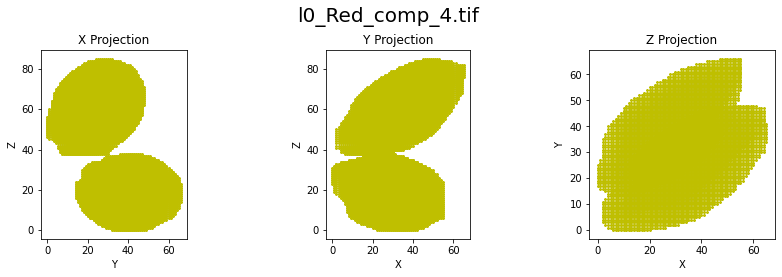

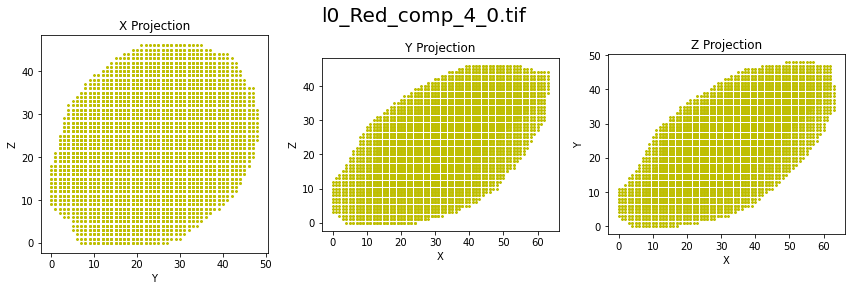

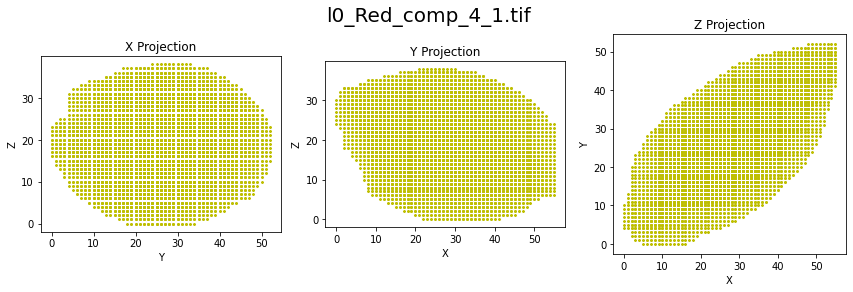

In [16]:
i=4
seed = tf.imread(dst + bname + '_comp_{}.tif'.format(i)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}.tif'.format(i))

i,j=4,0
seed = tf.imread(dst + bname + '_comp_{}_{}.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}_{}.tif'.format(i,j))

i,j=4,1
seed = tf.imread(dst + bname + '_comp_{}_{}.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}_{}.tif'.format(i,j))

From `extract_refinement`:

- `locs0`: (x,y,z) coordinates of the lower,left,front corner of the box containing the connected component with respect to the coordinates of the initial scan of cluster of seeds.
- `sizes0`: (width, height, depth) of the box containing the refined, individual seed
- `to_ignore`: list of components were we failed to split them into reasonably-sized components.

## Rename the seed templates

- If the template was initially a single seed (as it was the case for every component but the first 9), append a `_0` to their filename
- This will keep name format standard and easier to deal with

In [17]:
for i in range(start_seed, len(locs), 1):
    seed_file0 = dst + bname + '_comp_{}.tif'.format(i)
    seed_file  = dst + bname + '_comp_{}_0.tif'.format(i)
    os.rename(seed_file0, seed_file)

## Final pass on seed extraction: `seed_reconstruction`

- Our current templates were obtained with very aggressive thresholding and opening parameters, which might have destroyed everything but the hardest part of the grains.
- Now that we know the exact bounding box that contains each seed template, we want to see what other nonzero voxels are inside that box in the initial panicle scan.
- We expect to recover extra seed voxels, so we make the bounding box larger.
    - We have to be careful when the box is next to the original panicle scan boundaries.
- With the original nonzero voxels inside this bounding box, we perform a more gentle thresholding and opening operations.
- We expect to end with a single large connected component, which should be the seed.

In [18]:
brew.seed_reconstruction(src, dst, fname, locs, sizes, locs0, sizes0, start_seed, end_seed, to_ignore,
                        padding=padding, dil=dil, thr=thr, op=op, ero=ero, sigma=sigma,
                        write_file=write_file)

Observe that the templates look quite jaggy and voxelated compared to the actual, reconstructed seed.

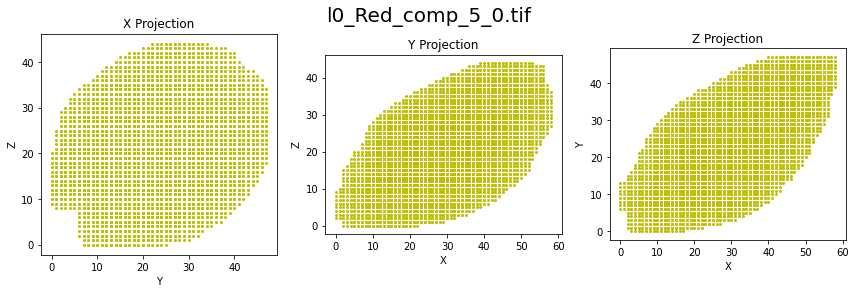

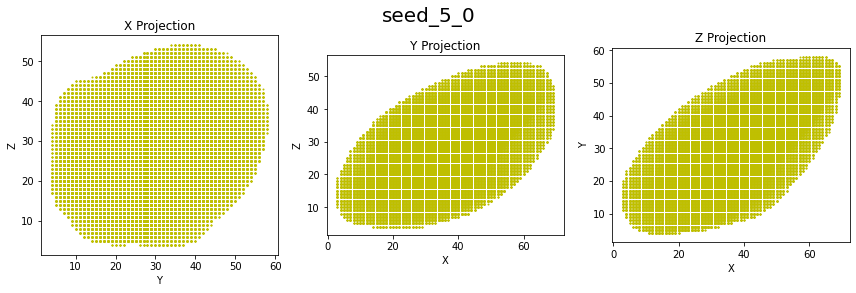

In [19]:
i,j=5,0
seed = tf.imread(dst + bname + '_comp_{}_{}.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}_{}.tif'.format(i,j))

seed = tf.imread(dst + 'seed_{}_{}_p7_d4_t120_o7_e1_g3.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, 'seed_{}_{}'.format(i,j))

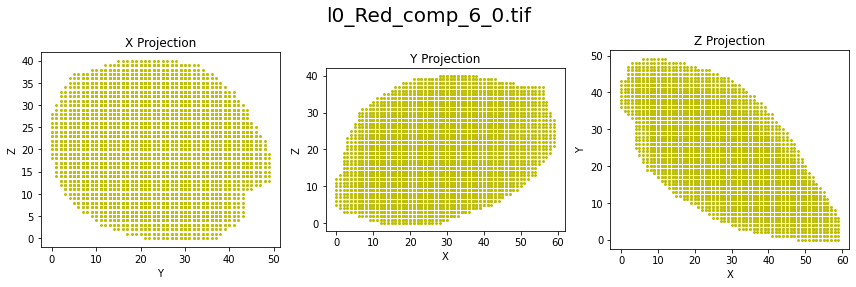

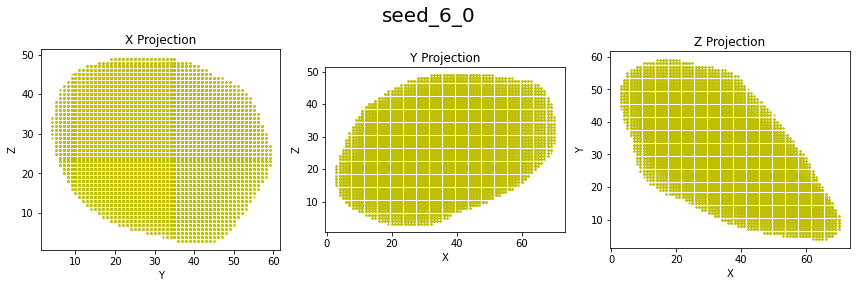

In [20]:
i,j=6,0
seed = tf.imread(dst + bname + '_comp_{}_{}.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, bname + '_comp_{}_{}.tif'.format(i,j))

seed = tf.imread(dst + 'seed_{}_{}_p7_d4_t120_o7_e1_g3.tif'.format(i,j)) 
xyzcoords = np.nonzero(seed)
xyzcoords = np.vstack(xyzcoords).T
misc.plot_3Dprojections(xyzcoords, 'seed_{}_{}'.format(i,j))

## Keep a record of seeds that weren't extracted

- For bookkeeping purposes, we can keep record of the templates that we failed to break up into individual seed templates (and thus failed to extract the seeds from the original panicle scan.)

In [23]:
missing_seeds = pd.DataFrame()
if len(to_ignore) > 0:
    df = brew.missing_summary(scanId, color, locs, sizes, to_ignore)
    missing_seeds = missing_seeds.append(df, ignore_index=True)
missing_seeds

,scan,color,seedNo,centerX,centerY,centerZ
0,example,Red,0,79.0,72.0,264.0
1,example,Red,1,91.0,79.0,372.0
2,example,Red,2,96.0,82.5,428.0
3,example,Red,3,66.5,86.5,318.0
4,example,Red,7,145.0,124.5,507.0


Save the list as a CSV

In [24]:
if not missing_seeds.empty:
    missing_seeds.to_csv(dst + scanId + '_ignore.csv', index=False)